# Cloud Motion Vector Calculations

The Cloud Motion Vector (CMV) package contained in `solartoolbox.cmv` is a package that implements cloud motion vector calculation methodologies from the literature. These methods are based on analysis of a distributed field of sensors. 

This demo utilizes sample data from a plant to demonstrate the application of the method.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from solartoolbox import cmv, spatial

## Read the Data
The sample data file is a compressed H5 file that contains all the info used to perform the analysis. 

### The Plant Layout
The layout of the plant is placed in the variable `pos_utm`. Its definition is contained in the field `latlon`, which produces a DataFrame of the combiner centroids in a UTM-like coordinate system. It contains combiner IDs as the index, and columns `E` and `N` that indicate the mean position of the combiner footprint (i.e. the centroid). The combiners are named following the pattern `CMB-<INVERTER#>-<COMBINER#>`.

### The Time Series Data
The method relies on time series data from a plant. Two examples are stored in the data file with keys `data_a` and `data_b`. These each represent one hour of data for each combiner in the plant with a 10s sampling resolution. The DataFrames are indexed by a time that is artificially offset to begin at a time of `00:00:00` on an arbitrary day. The columns of the DataFrames have keys that match the index of `pos_utm`. The two time periods are known to have a high variability and thus be well suited to the CMV calculation. 

In [2]:
datafile = "data/sample_plant_2.h5"
pos_utm = pd.read_hdf(datafile, mode="r", key="latlon")
df = pd.read_hdf(datafile, mode="r", key="data_a")

df

,CMB-001-1,CMB-001-2,CMB-001-3,CMB-001-4,CMB-001-5,CMB-001-6,CMB-001-7,CMB-002-1,CMB-002-2,CMB-002-3,...,CMB-047-7,CMB-047-8,CMB-048-1,CMB-048-2,CMB-048-3,CMB-048-4,CMB-048-5,CMB-048-6,CMB-048-7,CMB-048-8
2023-01-01 00:00:00,93.799402,93.985920,93.622077,94.318063,93.390276,93.459779,93.753268,95.253145,95.510679,95.718582,...,92.871630,92.798612,91.074627,91.385004,91.554207,91.528461,91.404796,91.747153,91.461591,91.606280
2023-01-01 00:00:10,94.508405,94.819152,95.028923,95.105311,93.855248,94.410892,94.540710,95.633790,95.760610,95.699990,...,92.753680,92.873880,91.292149,91.850400,91.644421,91.739311,91.842573,91.653509,91.475838,91.425386
2023-01-01 00:00:20,94.767218,95.245977,95.438032,95.826806,94.000549,94.737096,94.925867,95.603580,95.745574,95.265605,...,92.933072,92.732030,91.251834,91.799432,91.926831,91.726960,91.657963,91.725119,91.453577,91.490994
2023-01-01 00:00:30,94.880949,95.406670,95.139340,95.771861,94.032838,94.730620,95.055108,95.470650,95.914626,96.075220,...,92.942349,92.877739,91.443098,92.072665,91.937813,91.629913,91.534880,91.854972,91.431316,91.431947
2023-01-01 00:00:40,94.837813,95.538455,95.515880,95.826806,94.407401,94.698243,95.155677,95.337730,95.736634,95.525902,...,92.886374,92.751329,91.496539,92.014166,91.867211,91.532872,91.664974,91.688921,91.409054,91.577226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-01 00:59:20,14.373001,13.225903,14.791491,13.385478,13.085343,13.466051,14.118774,13.721180,13.306969,8.306490,...,14.580523,15.408295,14.735548,15.268503,15.645326,17.442542,17.913292,17.870185,16.114405,16.653684
2023-01-01 00:59:30,14.583977,13.338135,14.856895,13.349449,13.317424,13.456741,14.205222,13.811406,13.327289,8.690166,...,14.611648,15.615766,14.689607,14.798921,14.540775,16.176576,18.011441,18.704340,17.892674,19.351115
2023-01-01 00:59:40,14.610643,13.486927,14.896615,13.516509,13.312177,13.673675,14.273695,13.934259,13.347608,8.382548,...,14.247965,15.191175,14.563032,14.489767,14.585489,15.712535,15.359870,15.863494,18.463466,23.291351
2023-01-01 00:59:50,14.594957,13.737747,15.056860,13.734342,13.508587,13.867665,14.499656,13.958829,13.495051,8.701196,...,14.179527,14.860188,14.610850,14.564967,14.809852,15.814871,15.672231,16.217617,15.594370,17.694980


## Computing the CMV
The CMV calculation is performed by the `compute_cmv` function. The two methods used are the method of Gagne et al. and of Jamaly and Kleissl. Both methods involve computing the relative delays experienced throughout a field of sensor measurement points, as computed by the lagging cross correlation between the clearsky index time series of the sensors. These delays are induced by cloud motion over the plant, with downwind sensors experiencing a response to the time signal that is later than that experienced by upwind sensors. The differences between the two methods lie in the ways that they perform the analysis of the delay data in computing the CMV. Some differences also exist in the implementation of data quality control. 

### Gagne et al. Method
The method described by Gagne relies on a least squares regression between the spatial separations of the points and their relative delays to find the x and y components of the CMV vector. Quality control is used over the entire plant to select the sensors with the strongest mutual cross correlation, while still retaining a sufficient number of sensors for analysis. The full method is described in the paper:

- A. Gagné, N. Ninad, J. Adeyemo, D. Turcotte, and S. Wong, “Directional Solar Variability Analysis,” in 2018 IEEE Electrical Power and Energy Conference (EPEC) (2018) pp. 1–6, iSSN: 2381-2842. https://www.researchgate.net/publication/330877949_Directional_Solar_Variability_Analysis


### Jamaly and Kleissl Method
The method of Jamaly and Kleissl determines the CMV by finding the direction that minimizes the variance in the velocities computed using the delays and positions of the sensors. The magnitude of the vector is determined to be the median of these individual sensor velocities. A variety of statistical quality controls is applied both on a pairwise basis for individual pairs of sensors, and on an aggregate basis. 

- M. Jamaly and J. Kleissl, “Robust cloud motion estimation by spatio-temporal correlation analysis of irradiance data,” Solar Energy, vol. 159, pp. 306–317, Jan. 2018. https://www.sciencedirect.com/science/article/pii/S0038092X17309556 

### Implementation Details
#### Inputs and Reference Points
Both functions require the time series and positions within the field. The routine will read the site identifiers from the index of the `positions` DataFrame and will generate all possible combinations of pairings. These pairings will be used to perform analysis on columns of the `timeseries` DataFrame, so all index values in `positions` must be present. 

The optional `reference_id` parameter can contin a single reference identifier, or a list thereof, and can be used to limit the number of points used for the analysis. That is, rather than seeking all possible combinations of points, only pairwise combinations containing the members of `reference_id` will be considered. This can be particularly useful for time-sensitive applications.  

#### Data Conditioning
The published methods both assume that `timeseries` contains values of the clearsky index. In principle, however, any signals can be used subject to the caveat that oddities may be experienced due to mismatch with the value ranges expected by the QC. In the case of the example data from the plant combiners being demonstrated here, no clearsky index is available and no practical means exists to calculate one (i.e. what is the "clearsky" irradiance for a combiner?). Normalizing values to have a range similar to clearsky index is possible by computing for example the 95th quantile of the time series. The value of corr_scaling specified would also be likely to impact the ability of the QC to identify good data, as several QC criteria rely on the absolute value of the correlation. The default expected values of correlation correspond to the correltion coefficient scaling produced by `'coeff'`. Several customization options for the individual method QC are available via the `options` parameter, and are described in the docstring of the function. Notably, setting `minvelocity: 1` can be used by the `jamaly` method to limit unrealistically high values of the lag. 

#### Outputs
The function returns the speed and direction (in radians clockwise from east) of the CMV, as well as a `WindspeedData` object containing intermediate data from the calculation. Some interesting values include the list of pairings, individual correlation, lag and separation values for those pairings and the flags for each pair indicating the quality of the data. Definitions of the various flags are found in `solartoolbox.cmv.Flag`. The field `method_data` also includes some specific data outputs produced by the steps of the individual methods, or as part of their QC approaches.


In [3]:
hourlymax = np.mean(df.quantile(0.95))
kt = df / hourlymax 

cld_spd_gag, cld_dir_gag, dat_gag = cmv.compute_cmv(kt, pos_utm,
                                                    reference_id=None,
                                                    method='gagne',
                                                    corr_scaling='coeff')
cld_spd_jam, cld_dir_jam, dat_jam = cmv.compute_cmv(kt, pos_utm,
                                                    reference_id=None,
                                                    method='jamaly',
                                                    corr_scaling='coeff')

print("Method     Speed  Angle:rad  Angle:°   N_good")
print(f"Gagne   {cld_spd_gag:8.2f} {cld_dir_gag:10.2f} {np.rad2deg(cld_dir_gag):8.2f} {sum(dat_gag.pair_flag == cmv.Flag.GOOD):8,}")
print(f"Jamaly  {cld_spd_jam:8.2f} {cld_dir_jam:10.2f} {np.rad2deg(cld_dir_jam):8.2f} {sum(dat_jam.pair_flag == cmv.Flag.GOOD):8,}")

Method     Speed  Angle:rad  Angle:°   N_good
Gagne      11.47       0.20    11.20    1,861
Jamaly      9.52       0.62    35.50   22,383


## Inspecting the Results
Some instructive discussion can be motivated by the detailed results.

### Visualizing the Velocity Calculation
For both methods, the velocity is basically computed based on the aggregate $\Delta x / \Delta t$ across the entire plant. In the figure below, we show the plot of $\Delta x$ vs $\Delta t$ for all point pairs in the plant. The best fit line, whose slope indicates the velocity, is shown in red. The colorization indicates the value of the peak correlation, from which the lag was extracted. Higher correlation values indicate a better relationship between that particular pair of points. 

The repeated display of the figure shows magenta highlight on the points that were flagged passing the method's QC. These GOOD points were the only ones that were used in computing the best fit, which is also evident from the large group of points with unrealistically high lag on the right hand side of the figure. Points with a delay value of exactly zero were always excluded from the fit. It's interesting to note that some degree of digitization exists withiin the results due to the fact that only integer time steps are calculated when identifying the lag with maximum cross correlation. 

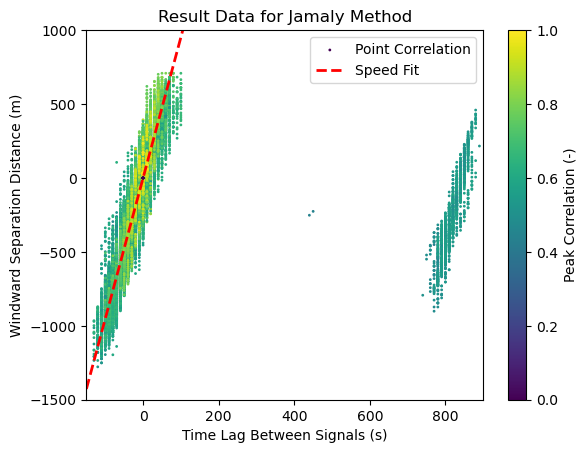

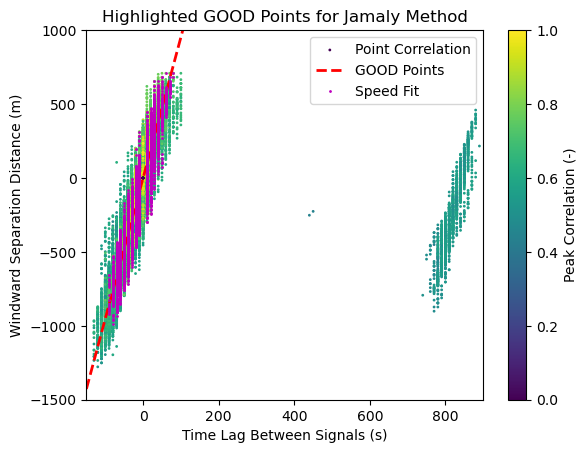

In [4]:
plt.title('Result Data for Jamaly Method')
plt.scatter(dat_jam.pair_lag, dat_jam.pair_dists, c=dat_jam.corr_lag, vmin=0, vmax=1, s=1)
plt.plot([-150, 200], cld_spd_jam * np.array([-150, 200]), 'r--', linewidth=2)  # Best Fit
plt.ylim([-1500, 1000])
plt.xlim([-150, 900])
plt.colorbar().set_label("Peak Correlation (-)")
plt.xlabel('Time Lag Between Signals (s)')
plt.ylabel('Windward Separation Distance (m)')
plt.legend(['Point Correlation', 'Speed Fit'])
plt.show()

plt.figure()
plt.title('Highlighted GOOD Points for Jamaly Method')
plt.scatter(dat_jam.pair_lag, dat_jam.pair_dists, c=dat_jam.corr_lag, vmin=0, vmax=1, s=1)
plt.plot([-150, 200], cld_spd_jam * np.array([-150, 200]), 'r--', linewidth=2)  # Best Fit
plt.plot(dat_jam.pair_lag[dat_jam.pair_flag == cmv.Flag.GOOD],
         dat_jam.pair_dists[dat_jam.pair_flag == cmv.Flag.GOOD], 'mo', markersize=1)
plt.ylim([-1500, 1000])
plt.xlim([-150, 900])
plt.colorbar().set_label("Peak Correlation (-)")
plt.xlabel('Time Lag Between Signals (s)')
plt.ylabel('Windward Separation Distance (m)')
plt.legend(['Point Correlation', 'GOOD Points', 'Speed Fit']);

### Visualizing the Lag Across the Field
A second interesting plot is that of the delay across the field. In order to visualize this case, we need to select a reference point from which we will compare all individual lag calculations within the plant. In this case, a centrally located combiner was chosen. Some initial calculation steps are required to extract lags involving the reference from the list of all possible sensor pairs. The arrow overplotted shows the computed CMV direction. The colorization indicates the lag relative to the reference. Positive values indicate that the point is upwind of the reference, while negative values indicate that the point is downwind. The outlier points with very high values of lag are present in the southeast corner of the plant.

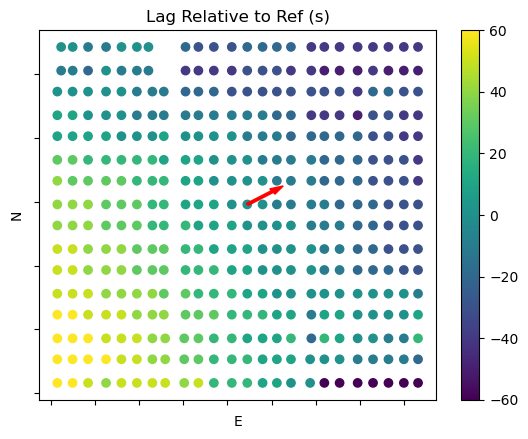

In [5]:
# Extract only the lags associated with the reference. Correct the lag's sign depending on which was the first point in the pair.
ref = 'CMB-022-5'
points = []
lags = []
for pair, lag in zip(dat_jam.allpairs, dat_jam.pair_lag):
    if ref in pair:
        point = pair[1] if ref == pair[0] else pair[0]
        lag_i = lag if ref == pair[0] else -lag
        points.append(point)
        lags.append(lag_i)

# Insert data back into the DataFrame for plotting
pos_utm['lag'] = np.zeros_like(pos_utm['E'])
pos_utm['lag'][points] = lags
pos_utm['lag'][ref] = 0


plt.scatter(pos_utm['E'], pos_utm['N'], c=-pos_utm['lag'], cmap='viridis')
vscale = 100
velvec = np.array(spatial.unit(spatial.pol2rect(cld_spd_jam, cld_dir_jam))) * vscale
plt.arrow(pos_utm['E'][ref], pos_utm['N'][ref], velvec[0], velvec[1], length_includes_head=True, width=7, head_width=20, color='red')
plt.clim(-60, 60)
plt.colorbar()
plt.xlabel('E')
plt.ylabel('N')
plt.title(f'Lag Relative to Ref (s)')
axes = plt.gca()
axes.xaxis.set_ticklabels([])
axes.yaxis.set_ticklabels([]);